Online Retail: Customer Segmentation Analysis <br>
By: Pranav Ravichandran

This notebook is designed to analyze customer data from an online store to group customers into different categories. By cleaning and preparing the data, we can better understand customer behavior and identify patterns. We’ll then group customers into segments that share similar traits, which can be used to tailor marketing strategies.

In this example, an online retailer wants to better understand their international customers by grouping them based on what they've bought in the past. This way, they can send more relevant offers and services to each group, rather than treating all customers the same.

Right now, they just group customers by their country, but this isn't very helpful because it ignores how much or how often people in each country actually buy. Some countries hardly have any customers, and not every customer from the same country buys in the same way.

This is an unsupervised learning task where the goal is to segment customers based on their buying patterns. The challenge is that we have transaction-level data, but the clusters need to be created at the customer level. First, we'll import the neccesary packages:

In [24]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score, davies_bouldin_score
import warnings

# Setting display options for better readability
pd.set_option('display.max_columns', 100)
warnings.filterwarnings("ignore")


The dataset consists of 35,116 records spanning 37 countries, containing transaction-level data without a target variable. Key features include invoice details (e.g., InvoiceNo, InvoiceDate), item details (e.g., StockCode, Quantity, UnitPrice), and customer details (e.g., CustomerID, Country).

In [25]:
# Loading the dataset
df = pd.read_csv('int_online_tx.csv')
print(df.shape)
df.head()

# Data Inspection
df.head(10)


(35116, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,12/1/10 8:45,3.75,12583.0,France
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,12/1/10 8:45,3.75,12583.0,France
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,12/1/10 8:45,3.75,12583.0,France
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,12/1/10 8:45,0.85,12583.0,France
4,536370,21883,STARS GIFT TAPE,24,12/1/10 8:45,0.65,12583.0,France
5,536370,10002,INFLATABLE POLITICAL GLOBE,48,12/1/10 8:45,0.85,12583.0,France
6,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,24,12/1/10 8:45,1.25,12583.0,France
7,536370,21035,SET/2 RED RETROSPOT TEA TOWELS,18,12/1/10 8:45,2.95,12583.0,France
8,536370,22326,ROUND SNACK BOXES SET OF4 WOODLAND,24,12/1/10 8:45,2.95,12583.0,France
9,536370,22629,SPACEBOY LUNCH BOX,24,12/1/10 8:45,1.95,12583.0,France


Each row represents a line item within a transaction rather than a complete transaction. This means multiple rows can belong to the same invoice, but each represents a different product purchased.

Next, we visualize the distribution of transactions by country.



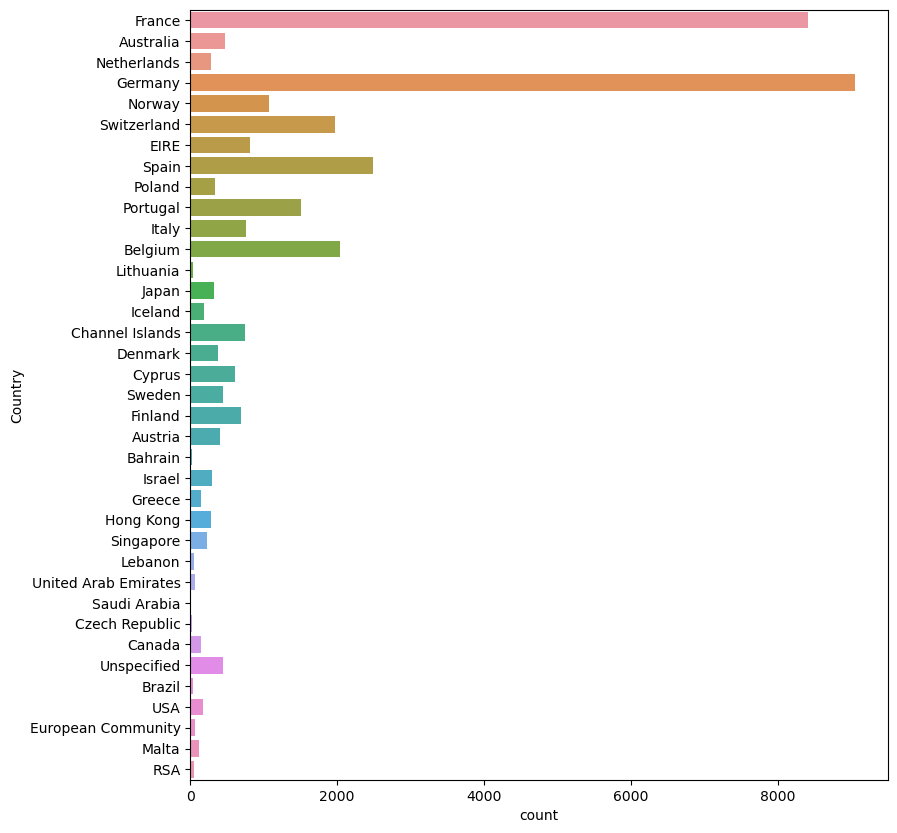

In [26]:
# Visualizing transactions by country
plt.figure(figsize=(9, 10))
sns.countplot(y='Country', data=df)
plt.show()

The plot reveals that certain countries have a very low number of transactions, highlighting the inefficiency of grouping customers solely by country.

Let's do some data cleaning, handling missing data:

In [28]:
# Checking for missing values
df.isnull().sum()

# Dropping rows with missing CustomerID and converting CustomerID to integer
df = df[df['CustomerID'].notnull()]
df['CustomerID'] = df['CustomerID'].astype(int)

Next, lets a create a sales feature and do some customer-level feature engineering:

In [12]:
# Creating a Sales feature
df['Sales'] = df['Quantity'] * df['UnitPrice']
df.head()

# Aggregating Invoice Data
invoice_data = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
invoice_data.columns = ['CustomerID', 'total_transactions']

# Aggregating Product Data
product_data = df.groupby('CustomerID')['StockCode'].agg(total_products=('count'), total_unique_products=('nunique')).reset_index()

# Aggregating Sales Data
sales_data = df.groupby('CustomerID')['Sales'].agg(total_sales=('sum'), avg_product_value=('mean')).reset_index()

# Aggregating Cart Data
cart_data = df.groupby(['CustomerID', 'InvoiceNo'])['Sales'].sum().reset_index()
cart_data.columns = ['CustomerID', 'InvoiceNo', 'cart_value']
agg_cart_data = cart_data.groupby('CustomerID')['cart_value'].agg(avg_cart_value=('mean'), min_cart_value=('min'), max_cart_value=('max')).reset_index()

# Joining the Aggregated Data
customer_df = pd.merge(invoice_data, product_data, on='CustomerID')
customer_df = pd.merge(customer_df, sales_data, on='CustomerID')
customer_df = pd.merge(customer_df, agg_cart_data, on='CustomerID')
customer_df.head()

# Saving the Analytical Base Table
customer_df.to_csv('analytical_base_table.csv', index=False)


The customer-level data is now aggregated and saved as an analytical base table, ready for clustering analysis.

Next we are going to perform RFM analysis. RFM (Recency, Frequency, Monetary) analysis is a customer segmentation technique that examines three key metrics to understand customer behavior and loyalty:

By incorporating RFM analysis into the customer segmentation process, we enrich the clustering model with meaningful features that directly correlate with customer engagement and value. This allows for more effective identification of distinct customer segments, which can then be targeted with personalized marketing strategies.

In [13]:
# Recency: Days since the last purchase
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
recency_data = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency_data['recency'] = (df['InvoiceDate'].max() - recency_data['InvoiceDate']).dt.days
recency_data = recency_data[['CustomerID', 'recency']]

# Frequency: Number of purchases
frequency_data = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency_data.columns = ['CustomerID', 'frequency']

# Monetary: Total amount spent
monetary_data = df.groupby('CustomerID')['Sales'].sum().reset_index()
monetary_data.columns = ['CustomerID', 'monetary']

# Merging RFM Data
rfm_data = pd.merge(recency_data, frequency_data, on='CustomerID')
rfm_data = pd.merge(rfm_data, monetary_data, on='CustomerID')

# Merging with the original customer dataframe
customer_df = pd.merge(customer_df, rfm_data, on='CustomerID')
customer_df.head()


,CustomerID,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,recency,frequency,monetary
0,12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,1,7,4310.00
1,12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,74,4,1797.24
2,12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,18,1,1757.55
3,12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,309,1,334.40
4,12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30,35,8,2506.04


When the number of features increases, it becomes harder to cluster the data effectively. Each additional feature increases the space in which the data points exist, making them appear more isolated.

In the next block, I introduced item-level data by creating dummy variables for each unique item. This significantly increases the number of features, leading to this issue. To help relieve this, I have applied PCA-- reducing 2,574 item features down to 300 principal components, capturing about 98% of the original variance.

In [35]:
# Creating Dummy Variables for Items
item_dummies = pd.get_dummies(df['StockCode'])
item_dummies['CustomerID'] = df['CustomerID']
item_data = item_dummies.groupby('CustomerID').sum()


## PCA

# Scaling the item data
scaler = StandardScaler()
item_data_scaled = scaler.fit_transform(item_data)

# Applying PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
PC_items = pca.fit_transform(item_data_scaled)

# Creating a DataFrame with PCA components
items_pca = pd.DataFrame(PC_items, index=item_data.index)
items_pca.columns = [f'PC{i+1}' for i in range(PC_items.shape[1])]
items_pca.head()

# Saving the PCA Item Data
items_pca.to_csv('pca_item_data.csv')


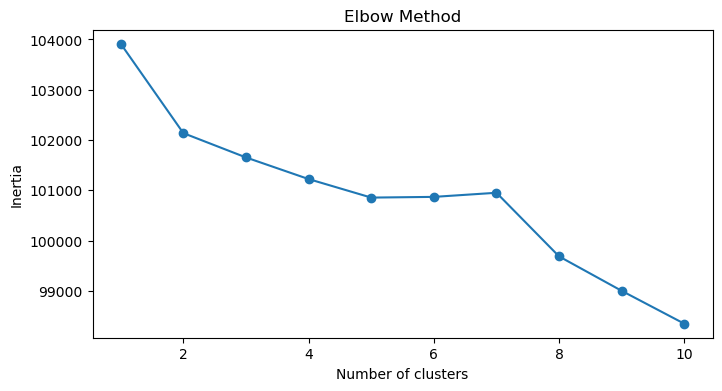

In [33]:
# Loading the analytical base table and PCA item data
base_df = pd.read_csv('analytical_base_table.csv')
pca_item_data = pd.read_csv('pca_item_data.csv', index_col=0)

# Ensure RFM data is included in base_df
rfm_data = pd.merge(recency_data, frequency_data, on='CustomerID')
rfm_data = pd.merge(rfm_data, monetary_data, on='CustomerID')

# Merging RFM data with base_df
base_df = pd.merge(base_df, rfm_data, on='CustomerID')

# Merging the datasets
pca_df = pd.merge(base_df, pca_item_data, on='CustomerID')

# Scaling the data
p_scaler = StandardScaler()
pca_df_scaled = p_scaler.fit_transform(pca_df.drop(columns=['CustomerID']))

# Determining the optimal number of clusters using the Elbow Method
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, init='k-means++', random_state=123)
    kmeans.fit(pca_df_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Applying KMeans with the optimal number of clusters
optimal_clusters = 3  # This can be adjusted based on the Elbow plot
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=123)
pca_df['cluster'] = kmeans.fit_predict(pca_df_scaled)


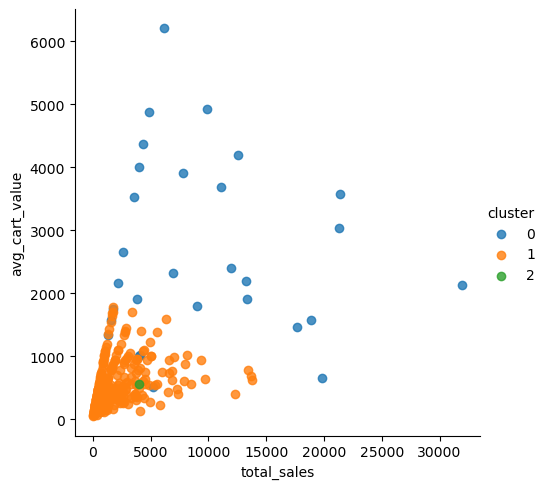

Silhouette Score: 0.17124737473380405
Davies-Bouldin Index: 3.5392996341939233


In [42]:
# Importing analytical base table and item data
base_df = pd.read_csv('analytical_base_table.csv')
pca_item_data = pd.read_csv('pca_item_data.csv', index_col=0)

# Joining item data with base table
pca_df = pd.merge(base_df, pca_item_data, on='CustomerID')
# Scaling data
p_scaler = StandardScaler()
pca_df_scaled = p_scaler.fit_transform(pca_df.drop(columns=['CustomerID']))

# KMeans clustering
p_kmeans = KMeans(n_clusters=3, init='k-means++', random_state=123)
pca_df['cluster'] = p_kmeans.fit_predict(pca_df_scaled)
# Visualizing clusters for PCA data
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster', data=pca_df, fit_reg=False)
plt.show()

silhouette_avg = silhouette_score(pca_df_scaled, pca_df['cluster'])
print(f'Silhouette Score: {silhouette_avg}')

# 2. Davies-Bouldin Index
db_score = davies_bouldin_score(pca_df_scaled, pca_df['cluster'])
print(f'Davies-Bouldin Index: {db_score}')

Conclusion

In this analysis, we successfully segmented customers for an online retailer by leveraging transaction-level data, RFM analysis, and dimensionality reduction techniques. By incorporating PCA, we reduced the complexity of the dataset, retaining essential variance while mitigating the curse of dimensionality. Our clustering model was evaluated using the Silhouette Score and the Davies-Bouldin Index, which provided insights into the cohesion and separation of the clusters.

While the Silhouette Score suggests moderate clustering quality, the Davies-Bouldin Index indicates there is room for improvement, with potential overlaps between clusters. These metrics, combined with visual inspection, suggest that further fine-tuning of the model or exploration of alternative clustering algorithms could enhance the segmentation quality. Ultimately, this analysis lays the groundwork for more targeted marketing strategies, helping the retailer better understand and serve their international customer base.